In [211]:
import numpy as np
import pandas as pd
import pystan
from scipy.stats import norm, multivariate_normal, invwishart, invgamma
from statsmodels.tsa.stattools import acf
import datetime
import sys
import os

from codebase.plot import * 
from codebase.data import * 
from codebase.file_utils import save_obj, load_obj

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
# log_dir = "./log/20191111_130325_comdataqsu1/"
# # ps = load_obj('ps', log_dir)
# # ps.keys()

In [214]:
mu = pd.read_csv("./log/20191111_130325_comdataqsu1/mu_df.csv").values
mu2 = pd.read_csv("./log/20191111_130325_comdataqsu1/mu2_df.csv").values

In [215]:
np.mean(mu[1583:, 108:])

0.002133992737124658

In [216]:
np.mean(mu[:1583, :108])

3.487079666011423e-05

In [217]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

dff = pd.read_csv("../dat/clean_iri_flag_data.csv")
# dff.iloc[1583:, 108:]
# dff.iloc[:1583, :108]

flags = np.zeros_like(dff.iloc[:,2:])
flags[1583:, 108:] = 1

np.mean(flags)*100

0.920747609388583

## Standardized u's

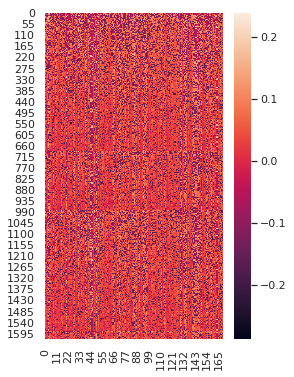

In [231]:
stdu = mu/np.sqrt(mu2 - mu**2)
plt.figure(figsize=(4,6))
ax = sns.heatmap(stdu, cbar = True )

In [237]:
a1 = flags.flatten()
a1.shape

(276080,)

In [238]:
a2 = stdu.flatten()
a2.shape

(276080,)

In [243]:
pct_cutoff = np.percentile(stdu, q=[50])
# a3 = a1[a2>pct_cutoff]
indx = a2>pct_cutoff
a3 = np.zeros_like(a2)
a3[indx]= 1
# a3.sum()

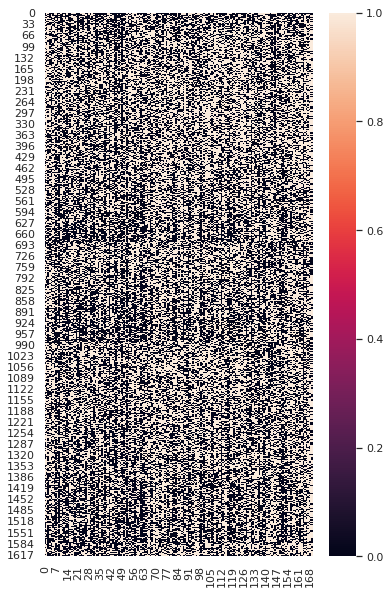

In [245]:
plt.figure(figsize=(6,10))
ax = sns.heatmap(a3.reshape(stdu.shape), cbar = True)

In [134]:
np.mean(flags)

0.0036221385105766443

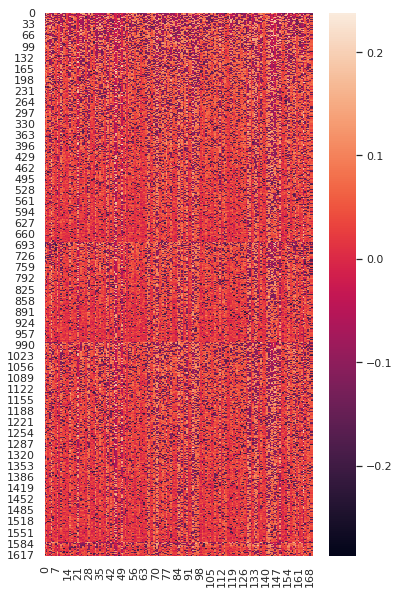

In [140]:
stdu = mu/np.sqrt(mu2 - mu**2)
plt.figure(figsize=(6,10))
ax = sns.heatmap(stdu, cbar = True )

In [143]:
np.mean(stdu[1583:, 108:])*100

1.073361565395652

In [144]:
np.mean(stdu[:1583, :108])*100

0.016966565073725504

In [152]:
pct_cutoff = np.percentile(stdu, q=[60])

In [208]:
pct_cutoff = np.percentile(stdu, q=[50])
pct_cutoff

# plt.figure(figsize=(6,10))
# ax = sns.heatmap(ind_a.reshape(1624, 170), cbar = False, cmap="YlGnBu" )

array([0.02422542])

In [210]:
np.median(stdu)

0.02422542397864043

In [ ]:

a = mu.flatten()
flags = np.zeros_like(a)
ind = np.argpartition(a, -topN)[-topN:]
flags[ind] = 1
# flags_df = flags.reshape(1624, 170)

plt.figure(figsize=(6,10))
ax = sns.heatmap(flags.reshape(1624, 170), cbar = False, cmap="YlGnBu" )

In [125]:
# topN = 100
# ind = np.argpartition(mu, -topN)[-topN:]

# topdf = np.zeros_like(dff)
# mu[ind]

# # plt.figure(figsize=(6,10))
# # ax = sns.heatmap(topdf, cbar = True, cmap="YlGnBu" )

In [93]:
topN = 10
topdf = np.zeros_like(dff)
for i in range(170):
    rowind = dfu[i].nlargest(topN).index
    topdf[rowind, i] = 1
topdf

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

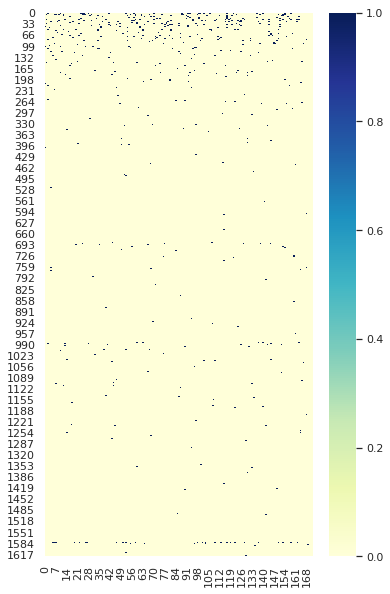

In [96]:
sns.set()
plt.figure(figsize=(6,10))
ax = sns.heatmap(topdf, cbar = True, cmap="YlGnBu" )

In [94]:
# dfu = pd.DataFrame(mu)
# max_subjs = dfu.idxmax() 
# max_subjs[108:]

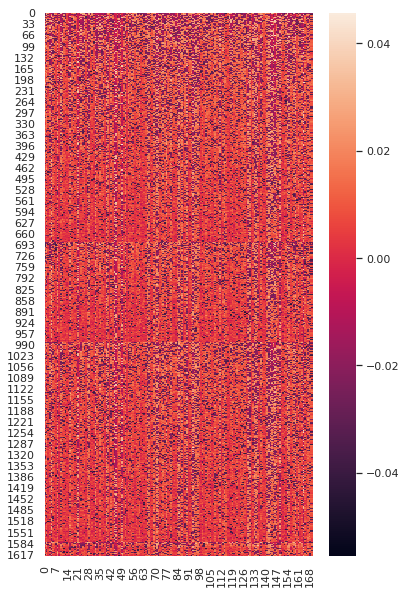

In [69]:
sns.set()
plt.figure(figsize=(6,10))
ax = sns.heatmap(mu, cbar = True )

## Residual Analysis

In [74]:
def get_residuals(mu, mu2, by_axis, absval = True, sort=False):
    """
    params
    ps_u posterior samples of u
    by_axis 0=residuals per iterm, 1=residuals per subject
    """
    mean_u = mu #mean posterior residual matrix
    std_u = np.sqrt(mu2 - mean_u**2) #std of posterior residual matrix
    if absval:
        res = pd.DataFrame(np.sum(np.abs(mean_u/std_u), axis=by_axis)).reset_index()
    else:
        res = pd.DataFrame(np.sum(mean_u/std_u, axis=by_axis)).reset_index()
    res.columns = ['index', 'residual']
    
    if sort:
        res.sort_values('residual', ascending=False, inplace=True)
    return res

get_residuals(mu, mu2, 1, False, True).head()


index  residual
620     620  2.299078
881     881  2.254899
1579   1579  2.237721
1603   1603  2.235500
322     322  2.158687

In [75]:
# %%opts Bars {+axiswise} [width=1000, height=300, ] 
res = get_residuals(mu, mu2, 1, False, True)

hv.Bars(res[:20], hv.Dimension('index'), 'residual',\
        label='Top 20 Residuals').options(color='blue', xrotation=90).options(fig_inches=8, aspect=3)


:Bars   [index]   (residual)

In [443]:
Z = np.mean(abs(ps['zz']), 0)
mean_flag = np.mean(Z[500:])
mean_flag

0.8965378028330893

In [ ]:
def get_heatmap_data(ps_u):
    """
    params
    ps_u posterior samples of u
    """
    mean_u = np.mean(ps_u, axis=0) #mean posterior residual matrix
    std_u = np.sqrt(np.mean(ps_u**2, axis=0)- mean_u**2) #std of posterior residual matrix
    res = mean_u/std_u
    return res
heatmap_data = get_heatmap_data(ps['uu'])

pd.DataFrame(heatmap_data).to_csv("log/plot_data/lsat_heatmap_data.csv", index=False)

In [444]:
mean_clean = np.mean(Z[:500])
mean_clean

0.7644791216458708

In [369]:
X = np.mean(abs(ps['uu']), 0)
mean_flag = np.mean(X[500:, 50:])
mean_flag

0.15989694101564933

In [370]:
mean_clean = np.mean(X[:500, :50])
mean_clean

0.15956367750994851

In [371]:
X = np.mean(ps['uu'], 0)
mean_flag = np.mean(X[500:, 50:])
np.round(mean_flag, 4)

0.0024

In [372]:
mean_clean = np.mean(X[:500, :50])
np.round(mean_clean, 4)

0.0001

In [376]:
X = np.mean(ps['uu'], 0).flatten().reshape([37870,1])
X.shape

(37870, 1)

In [377]:
y = np.zeros_like(data['D'])
y[500:, 50:] = 1
y = y.flatten()


In [378]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,
                         solver='lbfgs',
                         fit_intercept= True,
                        penalty = 'none').fit(X, y)

In [379]:
# clf.score(X,y)
print(clf.coef_, clf.intercept_)

[[8.37533549]] [-3.82064507]


In [380]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    

In [381]:
pred_probs = clf.predict_proba(X)[:,1]
pred_probs

array([0.01743364, 0.01901743, 0.01963851, ..., 0.02097552, 0.02024871,
       0.01600746])

In [382]:
auc = roc_auc_score(y, pred_probs)
print('AUC: %.2f' % auc)

AUC: 0.54


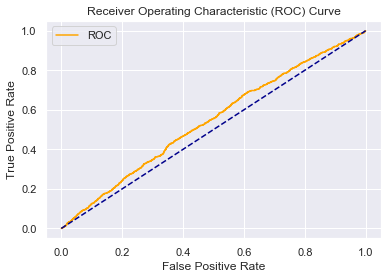

In [383]:
fpr, tpr, thresholds = roc_curve(y, pred_probs)
plot_roc_curve(fpr, tpr)


In [384]:
import statsmodels.api as sm

In [386]:
X = np.mean(ps['uu'], 0).flatten()
X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.104194
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                37870
Model:                          Logit   Df Residuals:                    37868
Method:                           MLE   Df Model:                            1
Date:                Fri, 01 Nov 2019   Pseudo R-squ.:                0.002015
Time:                        16:26:47   Log-Likelihood:                -3945.8
converged:                       True   LL-Null:                       -3953.8
Covariance Type:            nonrobust   LLR p-value:                 6.552e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8206      0.036   -107.146      0.000      -3.891      -3.751
x1             8.3753      2.132      3.929      0.000       4.197      12.553
==============================================================================
"""

In [387]:
result.predict(X)

array([0.01743363, 0.01901743, 0.0196385 , ..., 0.02097551, 0.02024871,
       0.01600745])

In [391]:
a = np.arange(12).reshape([4,3])
a.flatten().reshape([4,3])

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [396]:
predict_proba = result.predict(X).reshape([data['N'], data['J']])
mean_clean = np.mean(predict_proba[:500, :50])
np.round(mean_clean, 4)

0.0217

In [397]:
predict_proba = result.predict(X).reshape([data['N'], data['J']])
mean_clean = np.mean(predict_proba[500:, 50:])
np.round(mean_clean, 4)

0.0221

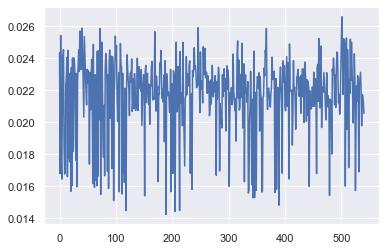

In [405]:
pd.DataFrame(predict_proba).iloc[:,30].plot()

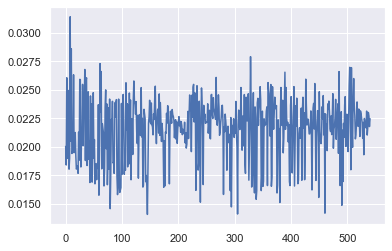

In [406]:
pd.DataFrame(predict_proba).iloc[:,53].plot()

In [408]:
%%opts Layout [fig_size=200]
plots = []
for n in [2,140]:
    for j in range(data['J']):
        plots.append(plot_trace(ps['uu'][:,n,j],
             title = 'Posterior distribution for u(%s,%s)'%(n,j)).\
                     options(fig_inches=8, aspect=3))
layout = hv.Layout(plots).options(show_title = True,
                                  vspace = .3,
                                  absolute_scaling=False,
                                  normalize=False) # use same y-range for all plots?

layout.cols(2)


:Layout
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_0_right_parenthesis    :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_1_right_parenthesis    :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_2_right_parenthesis    :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_3_right_parenthesis    :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_4_right_parenthesis    :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_5_right_parenthesis    :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_6_right_parenthesis    :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_7_right_parenthesis    :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_8_right_parenthesis    :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_9_right_parenthesis    :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_10_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_11_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_12_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_13_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_14_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_15_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_16_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_17_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_18_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_19_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_20_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_21_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_22_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_23_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_24_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_25_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_26_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_27_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_28_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_29_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_30_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_31_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_32_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_33_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_34_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_35_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_36_right_parenthesis   :Curve   [x]   (y)
   .Curve.Posterior_distribution_for_u_left_parenthesis_2_comma_37_rig

In [441]:
def get_heatmap_data(ps_u):
    """
    params
    ps_u posterior samples of u
    """
    mean_u = np.mean(ps_u, axis=0) #mean posterior residual matrix
    std_u = np.sqrt(np.mean(ps_u**2, axis=0)- mean_u**2) #std of posterior residual matrix
    res = mean_u
    return res
heatmap_data = get_heatmap_data(ps['uu'])

# pd.DataFrame(heatmap_data).to_csv("log/plot_data/irdat_heatmap_data.csv", index=False)

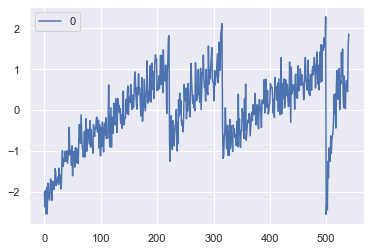

In [442]:
heatmap_data = get_heatmap_data(ps['zz'])
pd.DataFrame(heatmap_data).plot()
# pd.DataFrame(heatmap_data).to_csv("log/plot_data/irdat_heatmap_data.csv", index=False)

In [435]:
import seaborn as sns
import matplotlib.pyplot as plt

In [437]:
sns.set()
plt.figure(figsize=(10,10))
ax = sns.heatmap(heatmap_data[:,], cbar = True )

IndexError: Inconsistent shape between the condition and the input (got (541, 1) and (541,))

<Figure size 720x720 with 0 Axes>

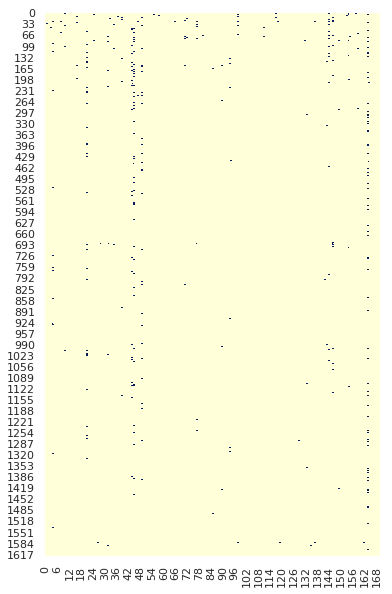

In [133]:
# topN = 1000
# a = mu.flatten()
# flags = np.zeros_like(a)
# ind = np.argpartition(a, -topN)[-topN:]
# flags[ind] = 1
# # flags_df = flags.reshape(1624, 170)

# plt.figure(figsize=(6,10))
# ax = sns.heatmap(flags.reshape(1624, 170), cbar = False, cmap="YlGnBu" )